In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

/Users/lujingyang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
try:
    df = pd.read_csv('/Users/lujingyang/Projects/car_price_analysis/data/raw/car_price_dataset.csv')
    print("Data Loaded！")
except FileNotFoundError:
    print("Cannot find the data!")

Data Loaded！


In [4]:
# Using Sample Dataset if No data
print("Using sample data:")
# Create sample dataset
np.random.seed(42)
n_samples = 500
year = np.random.randint(2000, 2023, n_samples)
km_driven = np.random.randint(1000, 150000, n_samples)
fuel = np.random.choice(['Petrol', 'Diesel', 'CNG', 'LPG', 'Electric'], n_samples)
seller_type = np.random.choice(['Individual', 'Dealer'], n_samples)
transmission = np.random.choice(['Manual', 'Automatic'], n_samples)
owner = np.random.choice(['First Owner', 'Second Owner', 'Third Owner'], n_samples)
mileage = np.random.uniform(10, 30, n_samples)
engine = np.random.randint(800, 3000, n_samples)
max_power = np.random.uniform(50, 200, n_samples)
seats = np.random.choice([2, 4, 5, 6, 7], n_samples)
# Create price relevant to the features
price = 50000 + (2023 - year) * -2000 + km_driven * -0.1 + \
            (fuel == 'Petrol') * 10000 + (transmission == 'Automatic') * 25000 + \
            engine * 20 + max_power * 500 + seats * 5000 + np.random.normal(0, 50000, n_samples)
price = np.maximum(price, 100000)  

Using sample data:


In [6]:
#Create Dataframe:
# 创建DataFrame
data = {
        'year': year,
        'km_driven': km_driven,
        'fuel': fuel,
        'seller_type': seller_type,
        'transmission': transmission,
        'owner': owner,
        'mileage': mileage,
        'engine': engine,
        'max_power': max_power,
        'seats': seats,
        'selling_price': price
}
df = pd.DataFrame(data)

In [7]:
#2 Data exploration analysis
print("\nData Overview:")
print(df.info())


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           500 non-null    int64  
 1   km_driven      500 non-null    int64  
 2   fuel           500 non-null    object 
 3   seller_type    500 non-null    object 
 4   transmission   500 non-null    object 
 5   owner          500 non-null    object 
 6   mileage        500 non-null    float64
 7   engine         500 non-null    int64  
 8   max_power      500 non-null    float64
 9   seats          500 non-null    int64  
 10  selling_price  500 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 43.1+ KB
None


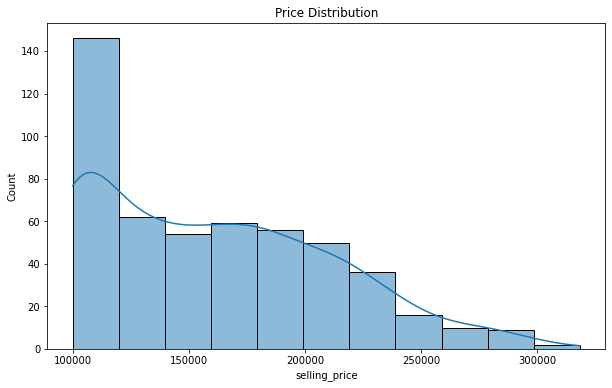

In [8]:
#3 Data Visulisation Analysis
plt.figure(figsize=(10, 6))
plt.title('Price Distribution')
sns.histplot(df['selling_price'], kde=True)
plt.show()

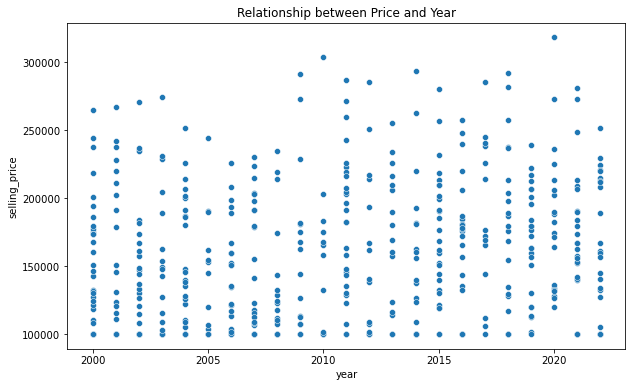

In [9]:
# Relationship between Price and Year
plt.figure(figsize=(10, 6))
plt.title('Relationship between Price and Year')
sns.scatterplot(x='year', y='selling_price', data=df)
plt.show()

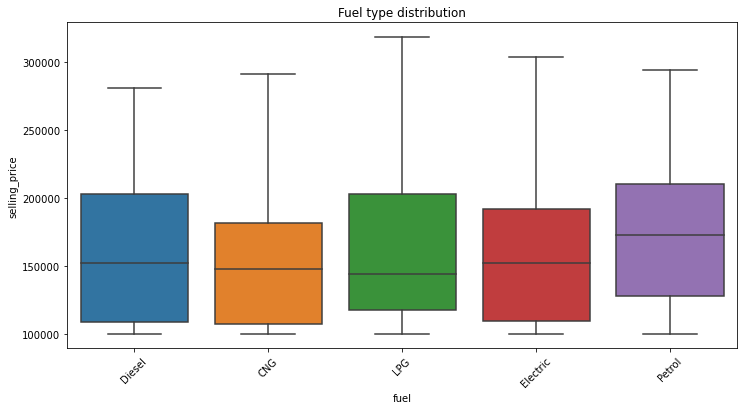

In [10]:
# Price distribution on fuel types
plt.figure(figsize=(12, 6))
plt.title('Price distribution on fuel types')
sns.boxplot(x='fuel', y='selling_price', data=df)
plt.xticks(rotation=45)
plt.show()

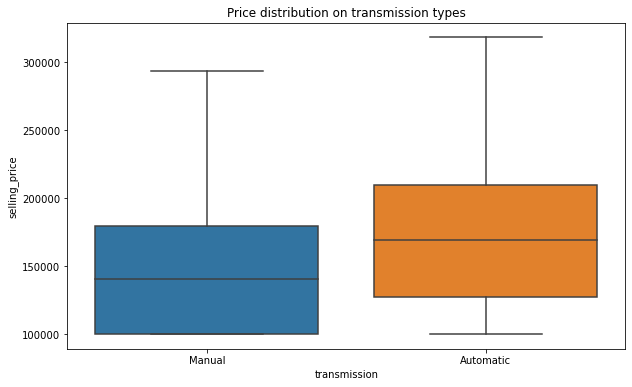

In [11]:
# Price distribution on transmission types
plt.figure(figsize=(10, 6))
plt.title('Price distribution on transmission types')
sns.boxplot(x='transmission', y='selling_price', data=df)
plt.show()

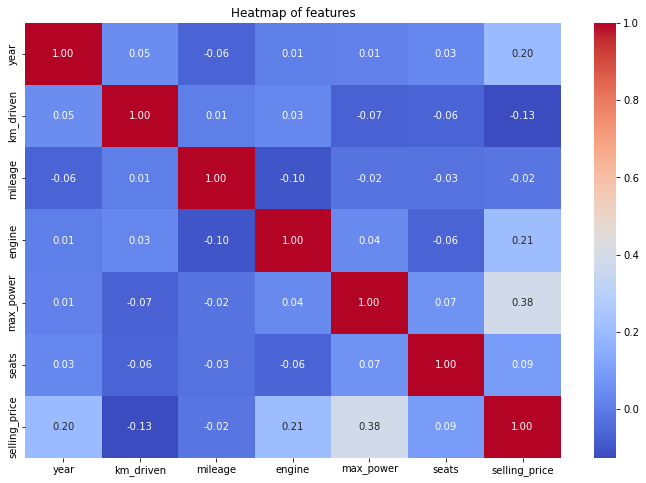

In [12]:
# Heatmap of features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
plt.title('Heatmap of features')
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [13]:
# Feature and target
try:
    X = df.drop(['selling_price'], axis=1)
    y = df['selling_price']
except KeyError as e:
    print(f"Can't find: {e}.")
    X = df.drop(['selling_price'], axis=1)
    y = df['selling_price']

In [15]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
Categorical features: ['fuel', 'seller_type', 'transmission', 'owner']


In [16]:
# Data preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
# Split training set and testing set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    return y_pred

In [20]:
# Liner Regression
print("\nLiner Regression Model:")
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
print("Liner Regression Model Evaluation:")
lr_pred = evaluate_model(lr_pipeline, X_test, y_test)


Liner Regression Model:
Liner Regression Model Evaluation:
MSE: 1941010781.55
RMSE: 44056.90
MAE: 36743.91
R²: 0.3443


In [21]:
# Ridge Regression
print("\nRidge Regression:")
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])
ridge_pipeline.fit(X_train, y_train)
print("Ridge Regression Evalution:")
ridge_pred = evaluate_model(ridge_pipeline, X_test, y_test)


Ridge Regression:
Ridge Regression Evalution:
MSE: 1941857476.93
RMSE: 44066.51
MAE: 36746.86
R²: 0.3440


In [22]:
# Lasso Regression
print("\nLasso Regression Model:")
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1))
])
lasso_pipeline.fit(X_train, y_train)
print("Lasso Regression Model Evaluation:")
lasso_pred = evaluate_model(lasso_pipeline, X_test, y_test)


Lasso Regression Model:
Lasso Regression Model Evaluation:
MSE: 1941011635.91
RMSE: 44056.91
MAE: 36743.86
R²: 0.3443


In [25]:
# Random Forest
print("\nRandom Forest Model:")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
print("Random Forest Model Evaluation:")
rf_pred = evaluate_model(rf_pipeline, X_test, y_test)


Random Forest Model:
Random Forest Model Evaluation:
MSE: 2066915838.71
RMSE: 45463.35
MAE: 37318.90
R²: 0.3017


In [27]:
# Gradient Boosting Regression
print("\nGradient Boosting Regression Model:")
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=50, random_state=42))
])
gb_pipeline.fit(X_train, y_train)
print("Gradient Boosting Regression Model Evaluation:")
gb_pred = evaluate_model(gb_pipeline, X_test, y_test)


Gradient Boosting Regression Model:
Gradient Boosting Regression Model Evaluation:
MSE: 2117700195.66
RMSE: 46018.48
MAE: 37977.12
R²: 0.2846


In [28]:
# SVR
print("\nSVR Model (Liner core):")
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear'))
])
svr_pipeline.fit(X_train, y_train)
print("SVR Model Evaluation:")
svr_pred = evaluate_model(svr_pipeline, X_test, y_test)


SVR Model (Liner core):
SVR Model Evaluation:
MSE: 2963267462.01
RMSE: 54435.90
MAE: 45553.72
R²: -0.0011



Models Comparation:


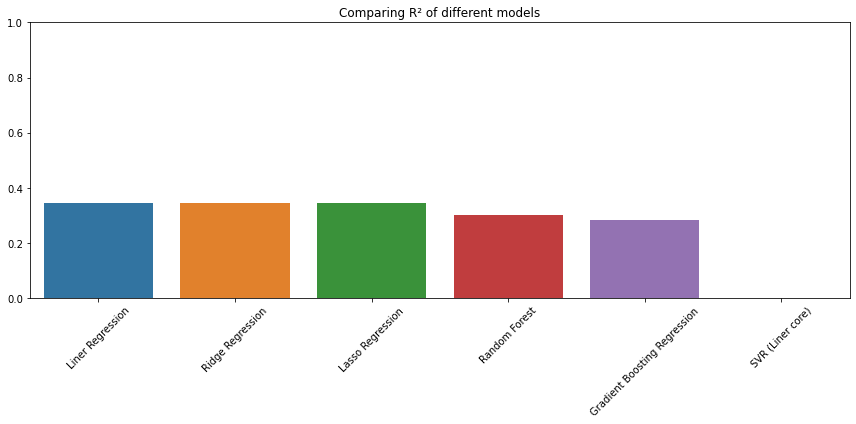

In [36]:
# 6. Models Comparation
print("\nModels Comparation:")
models = ['Liner Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting Regression', 'SVR (Liner core)']
predictions = [lr_pred, ridge_pred, lasso_pred, rf_pred, gb_pred, svr_pred]

# R²
r2_scores = [r2_score(y_test, pred) for pred in predictions]

plt.figure(figsize=(12, 6))
plt.title('Comparing R² of different models')
sns.barplot(x=models, y=r2_scores)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# Model Selection
best_model_index = np.argmax(r2_scores)
best_model_name = models[best_model_index]
print(f"\nThe best model is: {best_model_name}, R² = {r2_scores[best_model_index]:.4f}")


The best model is: Liner Regression, R² = 0.3443


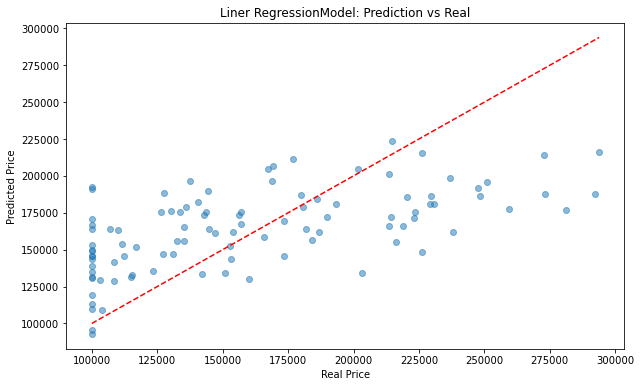

In [33]:
# Prediction Scatter
plt.figure(figsize=(10, 6))
plt.title(f'{best_model_name}Model: Prediction vs Real')
plt.scatter(y_test, predictions[best_model_index], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.show()

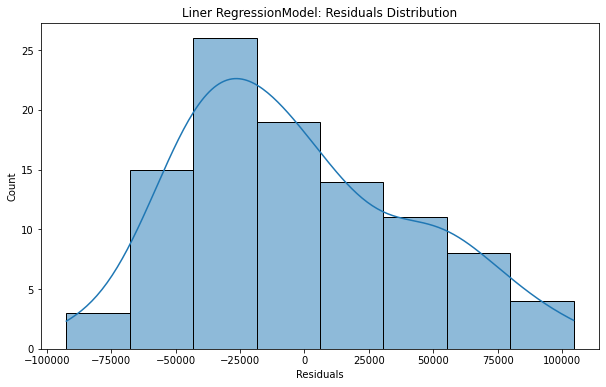

In [34]:
# Residuals Analysis
residuals = y_test - predictions[best_model_index]
plt.figure(figsize=(10, 6))
plt.title(f'{best_model_name}Model: Residuals Distribution')
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.show()

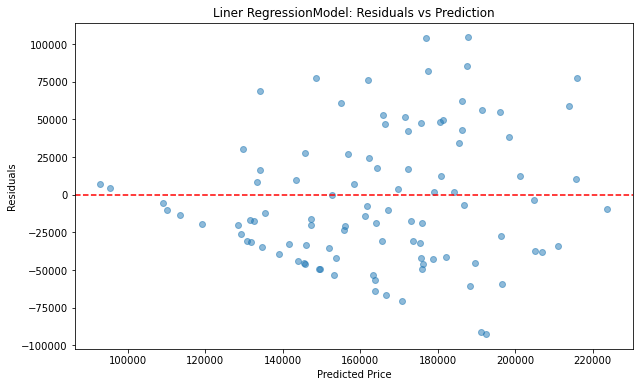

In [35]:
plt.figure(figsize=(10, 6))
plt.title(f'{best_model_name}Model: Residuals vs Prediction')
plt.scatter(predictions[best_model_index], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

In [37]:
# 8. Optimize the best model

if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10]
    }
    model_pipeline = rf_pipeline
    
elif best_model_name == 'Gradient Boosting Regression':
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    }
    model_pipeline = gb_pipeline
    
elif best_model_name == 'Ridge Regression':
    param_grid = {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
    }
    model_pipeline = ridge_pipeline
    
elif best_model_name == 'Lasso Regression':
    param_grid = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0]
    }
    model_pipeline = lasso_pipeline
    
elif best_model_name == 'SVR (Liner core)':
    param_grid = {
        'regressor__C': [0.1, 1, 10, 100],
        'regressor__epsilon': [0.01, 0.1, 0.2]
    }
    model_pipeline = svr_pipeline
    
else:
    print("No parameter can be optimized for Liner Regression.")
    param_grid = {}
    model_pipeline = lr_pipeline

if param_grid:
    print(f"Grid searching{best_model_name}...")
    grid_search = GridSearchCV(
        model_pipeline, 
        param_grid, 
        cv=5, 
        scoring='r2',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.4f}")
    
    print("\nUsing best parameters to estimate:")
    best_model = grid_search.best_estimator_
    best_pred = evaluate_model(best_model, X_test, y_test)
    
    if best_model_name in ['Random Forest', 'Gradient Boosting Regression']:
        # Get the features
        preprocessor = best_model.named_steps['preprocessor']
        regressor = best_model.named_steps['regressor']
        
        try:
            cat_features = []
            if categorical_features:
                cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
                cat_features = cat_encoder.get_feature_names_out(categorical_features).tolist()
            
            all_features = numeric_features + cat_features
            
            # Get feature importances
            feature_importances = regressor.feature_importances_
            
            fi_df = pd.DataFrame({
                'Features:': all_features,
                'Improtances': feature_importances
            })
            
            # Ranking the features based on importances
            fi_df = fi_df.sort_values('Importances', ascending=False).head(20)
            
            plt.figure(figsize=(12, 8))
            plt.title(f'{best_model_name} Model: Importance of Features')
            sns.barplot(x='Importance', y='Feature', data=fi_df)
            plt.tight_layout()
            plt.show()
        except:
            print("Can't obtain feature importance")

No parameter can be optimized for Liner Regression.


In [38]:
# 9. Prediction using model
# Create fake dataset
fake_data = pd.DataFrame({
    'year': [2019],
    'km_driven': [45000],
    'fuel': ['Petrol'],
    'seller_type': ['Individual'],
    'transmission': ['Manual'],
    'owner': ['First Owner'],
    'mileage': [18.5],
    'engine': [1500],
    'max_power': [110],
    'seats': [5]
})

if param_grid: 
    predicted_price = best_model.predict(fake_data)[0]
else:
    best_pipeline = [lr_pipeline, ridge_pipeline, lasso_pipeline, rf_pipeline, gb_pipeline, svr_pipeline][best_model_index]
    predicted_price = best_pipeline.predict(fake_data)[0]

print("Fake car dataset:")
print(fake_data)
print(f"Predicted Price: {predicted_price:.2f}")

Fake car dataset:
   year  km_driven    fuel seller_type transmission        owner  mileage  \
0  2019      45000  Petrol  Individual       Manual  First Owner     18.5   

   engine  max_power  seats  
0    1500        110      5  
Predicted Price: 166821.58


In [40]:
# 10. Conclusion
print("\nConclusion:")
print(f"1. The best model is {best_model_name}，its R² score is {r2_scores[best_model_index]:.4f}")
print("2. The main features relevant to price：")
if best_model_name in ['Random Forest', 'Gradient Boosting Regression'] and 'fi_df' in locals():
    for i, row in fi_df.head(5).iterrows():
        print(f"   - {row['feature']}: {row['importance']:.4f}")
else:
    print("   - Year（The new car will have higher price.）")
    print("   - KM_driven")
    print("   - Transmission（Auto will be higher than Manual）")
    print("   - Fuel")


Conclusion:
1. The best model is Liner Regression，its R² score is 0.3443
2. The main features relevant to price：
   - Year（The new car will have higher price.）
   - KM_driven
   - Transmission（Auto will be higher than Manual）
   - Fuel
